In [2]:
import pandas as pd
from os.path import abspath
from sklearn.model_selection import KFold,train_test_split
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score,accuracy_score,precision_score,recall_score
import sklearn as sk
from numpy.random import randint
return_sigs_filename = "RMData.csv"
geometries_filename = "B.csv"

In [3]:
def create_options_dict(options_dict={}):
    solvers = ['lbfgs','sag','saga','newton-cg']
    penalties = ['l1','l2','elasticnet','none'] 
    for i in range(len(solvers)):
        for j in range(len(penalties)):
            label = str(i)+str(j)
            options_dict.update({
                label:{
                    "solver":solvers[i],
                    "penalty":penalties[j]
                }
            })
    return options_dict

def create_working_list(options_dict=create_options_dict(),working_list=[]):
    for option in options_dict.keys():
        try:
            options = options_dict[option]
            solver = options["solver"]
            penalty = options["penalty"]
            setting = Settings(solver,penalty)
            m = Model(x,y,s=setting)
            working_list.append(options)
        except:
            continue
    return working_list
options_list = [
 {'solver': 'lbfgs', 'penalty': 'l2'},
 {'solver': 'sag', 'penalty': 'l2'},
 {'solver': 'saga', 'penalty': 'l1'},
 {'solver': 'saga', 'penalty': 'l2'},
 {'solver': 'saga', 'penalty': 'elasticnet'},
 {'solver': 'newton-cg', 'penalty': 'l2'}]

In [45]:
def kfolds(x,y,n_splits=3):
    X = x.values
    Y = y.values
    kf = KFold(n_splits=n_splits,shuffle=True)
    splits = {}
    i = 1
    for train_index, test_index in kf.split(X):
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        split_dict = {
            "x_train":x_train,
            "x_test":x_test,
            "y_train":y_train,
            "y_test":y_test
        }
        splits.update({i:split_dict})
        i+=1
    return splits

In [4]:
#derived from output of above functions
#to reduce overhead in comparison testing
working_list = options_list
x = return_signals = pd.read_csv(return_sigs_filename)
y = geometries = pd.read_csv(geometries_filename)
y = y.values.ravel() 

#changing implicit datatype to allow for categorical treatment
#y.loc[:,"1"] = y.loc[:,"1"].astype("object")
#basically a pivot
#y = pd.get_dummies(y)
#reformatting column headers to return to numerals
#y.columns = [x.split("_")[-1] for x in y.columns]

In [5]:
class Settings():   
    def __init__(self,solver:str,penalty:str):
        self.solver = solver
        self.penalty = penalty
        self.l1_ratio = 0.5             #when elasticnet, ratio of l1 to l2
        self.max_iter = 1e3
        self.avg_set = "weighted"
        self.n_jobs = -1
        self.c = int(1e-3)
        self.n_splits = 2
        self.random_state = None
        self.test_size = .3

class Model():
    def create_model(self):
        sv = self.s.solver
        p = self.s.penalty
        mi = self.s.max_iter
        nj = self.s.n_jobs
        c = self.s.c
        if (p == "elasticnet"and sv == "saga"):
            l1r = self.s.l1_ratio
            return LogReg(solver=sv,penalty=p,l1_ratio=l1r,max_iter=mi,n_jobs=nj)#,C=c)
        else:
            return LogReg(solver=sv,penalty=p,max_iter=mi,n_jobs=nj)#,C=c)

    def conf_mat(self,display=False):
        if display==False:
            return confusion_matrix(self.ytest,self.ypred)
        else:
            return ConfusionMatrixDisplay.from_predictions(self.ytest,self.ypred)

    def __init__(self,x,y,s=Settings("newton-cg","l2")):
        self.x = x
        self.y = y
        self.s = s #settings
        self.xtrain,self.xtest,self.ytrain,self.ytest=train_test_split(self.x,self.y,test_size=self.s.test_size,random_state=self.s.random_state)
        self.model = self.create_model().fit(self.xtrain,self.ytrain)
        self.ypred = self.model.predict(self.xtest)
        #self.accuracy = accuracy_score(self.ytest,self.ypred)
        self.bal_score = balanced_accuracy_score(self.ytest,self.ypred)
        self.precision = precision_score(self.ytest,self.ypred,average=self.s.avg_set,zero_division=0)
        self.recall = recall_score(self.ytest,self.ypred,average=self.s.avg_set,zero_division=0)

m = Model(x,y)


With smaller datasets, instead of full cross-validation, single subsets of test/train (sometimes an add'l validation group) can be used. We would like to avoid overfitting to the extent we can with the data as it exists.

By running each Model 10x, I essentially performed an un-sophisticated cross validation but with larger test/train groups and more shuffling than is typical. I could have used sklearn for cross validation, which might have been more efficient. I also could have set a random state for each for a more apples-to-apples comparison of models, but prefer the robustness ideally achieved by this method.

I'm now going to summarize the data in order to determine which combo of penalty/optimizer to focus attention on optimizing.

In [48]:
wl = options_list   #list of compatible solver/penatly combos
cwd = abspath('')      
filename = cwd + "/log_reg.csv"
df = pd.read_csv(filename)  #first used to output csv, now reading
df.head()

,iter,solver,penalty,precision,recall
0,0,lbfgs,l2,0.556723,0.588235
1,1,lbfgs,l2,0.849510,0.500000
2,2,lbfgs,l2,0.730392,0.617647
3,3,lbfgs,l2,0.742157,0.647059
4,4,lbfgs,l2,0.690196,0.529412


In [49]:
groups = ["solver","penalty"]

df_counts = df.drop(["precision","recall"],axis=1)
df_counts = df_counts.groupby(groups).count()
df_counts.columns = ["iters"]

df_means = df.drop(["iter"],axis=1)
df_means = df_means.groupby(groups).mean()

merged_df = df_counts.merge(df_means,on=groups)
merged_df.head(10)

iters  precision    recall
solver    penalty                               
lbfgs     l2             10   0.691555  0.579412
          none           10   0.662136  0.614706
newton-cg l2             10   0.665756  0.605882
          none           10   0.765224  0.700000
sag       l2             10   0.659132  0.585294
          none           10   0.786982  0.717647
saga      elasticnet     10   0.450588  0.400000
          l1             10   0.215413  0.223529
          l2             10   0.725294  0.661765
          none           10   0.761078  0.676471

true positive rate = recall,
false positive rate = fallout,
true negative rate = specificity,
false negative rate = miss rate

there are other ways of measuring the performance of a predicted state, but in my limited experience, I most commonly see precision/recall. Depending on our desired outcome, we might choose to bias a particular measurement.

precision = true pos/(true pos + false pos)
recall = true pos/(true pos + false neg)

the combos with the highest in each were sag/none and newton-cg/none, so let's pursue those further to see if we can dial in better optimization parameters

In [50]:
test_size = [x/100 for x in range(60,81,10)]
cs = [1/(10**y) for y in range(-3,3)]

def test_models(working_list=working_list,
                x=x,y=y,
                test_size=test_size,
                runs = 1,
                random_states=2,
                ):
    rss=[None]
    if random_states>0:
        rss += [randint(100) for z in range(random_states)]

    i = "iter"
    s = "solver"
    py = "penalty"
    ts = "test_size"
    rs = "random_state"
    pn = "precision"
    r = "recall"
    b = "bal accuracy"
    res = {i:[],s:[],py:[],ts:[],rs:[],pn:[],r:[],b:[],}  
    for w in working_list:
        for testsize in test_size:
            for randst in rss:
                for j in range(runs):
                    res[i].append(j)
                    solver = w["solver"]
                    res[s].append(solver)
                    penalty = w["penalty"]
                    res[py].append(penalty)
                    setting = Settings(solver,penalty)
                    setting.random_state = randst
                    res[rs].append(randst)
                    setting.test_size = testsize
                    res[ts].append(testsize)
                    model = Model(x,y,s=setting)
                    res[pn].append(model.precision)
                    res[r].append(model.recall)
                    res[b].append(model.bal_score)
                    #print(vars(setting))
    return pd.DataFrame.from_dict(res)

/Users/Fr333y3d3a/miniconda3/envs/math857/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/Fr333y3d3a/miniconda3/envs/math857/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Fr333y3d3a/miniconda3/envs/math857/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/Fr333y3d3a/miniconda3/envs/math857/lib/pyt

In [51]:
random_states = 2
runs = 2
df = test_models(test_size=test_size,runs=runs,random_states=random_states)
df.head()

/Users/Fr333y3d3a/miniconda3/envs/math857/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/Fr333y3d3a/miniconda3/envs/math857/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

,iter,solver,penalty,test_size,random_state,precision,recall,bal accuracy
0,0,lbfgs,l2,0.6,NaN,0.437262,0.407407,0.451905
1,1,lbfgs,l2,0.6,NaN,0.450642,0.358025,0.371746
2,0,lbfgs,l2,0.6,62.0,0.465165,0.419753,0.478730
3,1,lbfgs,l2,0.6,62.0,0.465165,0.419753,0.478730
4,0,lbfgs,l2,0.6,81.0,0.378120,0.407407,0.474603


In [54]:
df = df.drop("iter",axis=1)
df = df.groupby(by = ['solver', 'penalty', 'test_size', 'random_state']).mean()

In [64]:
bala = df.loc[:,"bal accuracy"]
def quantile(series:list,ratio=0.95):
    series = series.sort_values()
    s_len = len(series)
    q_len = int(s_len*ratio)
    tops = [i for i in range(s_len) if i >= q_len]
    return series[q_len:]
df_filtered = df.loc[quantile(bala).index,:]
df_filtered
test_models(options_list = [
            {'solver': 'lbfgs', 'penalty': 'l2'},
            {'solver': 'saga', 'penalty': 'l2'}],
            test_size=[.6]
            random_states=0
            runs=10
            )

,,,,precision,recall,bal accuracy
solver,penalty,test_size,random_state,,,
saga,l2,0.6,62.0,0.460492,0.419753,0.47873
lbfgs,l2,0.6,62.0,0.465165,0.419753,0.47873


/Users/Fr333y3d3a/miniconda3/envs/math857/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


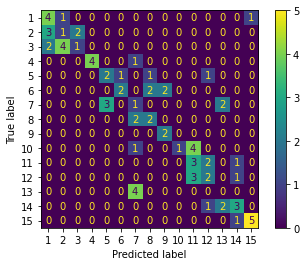

In [6]:
s1 = Settings("lbfgs","l2")
s1.test_size=.6
model1 = Model(x,y,s=s1)
model1.conf_mat(display=True)

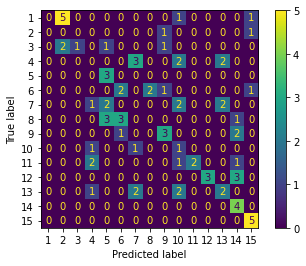

In [7]:
s2 = Settings("saga","l2")
s2.test_size=.6
model2 = Model(x,y,s=s2)
model2.conf_mat(display=True)